In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

plt.rcParams['font.size'] = 16

In [2]:
def get_audio_data(data: dict, attr: str, sample_id="all"):
    if sample_id == "all":
        values = np.array([value["audio"][attr] for value in data.values()]).reshape(-1)
    else:
        values = np.array(data[str(sample_id)]["audio"][attr]).reshape(-1)
    return values
    

def get_data(data: dict, name: str, model: str, attr: str, sample_id="all"):
    assert name != "audio", "please use func 'get_audio_mean_value'."
    if sample_id == "all":
        values = np.array([value[name][model][attr] for value in data.values()]).reshape(-1)
    else:
        values = np.array(data[str(sample_id)][name][model][attr]).reshape(-1)
    return values

In [3]:
import scipy as sp
from scipy import stats as st
import statsmodels.formula.api as smf
import statsmodels.api as sm
import statsmodels.stats.anova as anova # 分散分析するライブラリ
from statsmodels.stats.multicomp import pairwise_tukeyhsd # Tukeyの多重較するライブラリ

%precision 5
def tukey_hsd(ind, *args):
    # 第1引数:名称のリスト（index）, 第2引数以降: データ (*args: 複数の引数をタプルとして受け取る)
    data_arr = np.hstack(args) 
    # 配列の結合をhstackでしているらしい．水平方向（新しく列を増やしている方向）に結合．horizontalのhかと
    ind_arr = np.array([])
    for x in range(len(args)):
        ind_arr = np.append(ind_arr, np.repeat(ind[x], len(args[x]))) 
    # ind_arrの配列の最後にnp.repeat（)を加える
    # np.repeat(A,N)は配列A内の各要素をN回繰り返す
    print(pairwise_tukeyhsd(data_arr,ind_arr))

In [4]:
df = pd.read_csv("result/saved.csv")
df.head()

,personality_audio,personality_gt_mute,personality_gt,personality_icmi_mute,personality_icmi,personality_low_mute,personality_low,personality_mid_mute,personality_mid,personality_high_mute,...,nat_gt,nat_icmi,nat_low,nat_mid,nat_high,nat_gt_commu,nat_icmi_commu,nat_low_commu,nat_mid_commu,nat_high_commu
0,4,4,6,4,5,2,2,2,1,4,...,7,6,3,2,7,5,6,6,6,6
1,3,6,2,5,3,2,2,4,3,5,...,3,4,1,4,6,5,5,1,4,4
2,5,5,2,5,6,2,3,6,3,6,...,6,7,5,6,6,6,6,5,5,7
3,3,6,5,4,5,2,2,2,1,5,...,4,6,2,2,2,2,3,1,3,3
4,3,5,7,5,5,2,2,4,3,7,...,7,6,2,4,5,4,4,6,5,3


In [5]:
def annotate_between_bar(*bar_indexs, bottom_height, text, upper_height=None):
    # statistical annotation
    if upper_height is None:
        upper_height = bottom_height + 0.2
    x1, x2 = bar_indexs   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    ax.plot([x1, x1, x2, x2], [bottom_height, upper_height, upper_height, bottom_height], lw=1.5, color="black")
    ax.text((x1+x2)*.5, upper_height+0.1, text, ha='center', va='bottom',  color="black")

# Extroversion
1. with audio condition & test
2. commu condition & test

In [6]:
print("Extroversion, with audio condition, avatar")

dataset = [
    df["personality_gt"],
    df["personality_icmi"],
    df["personality_low"],
    df["personality_mid"],
    df["personality_high"],
]

labels = [
    "GT",
    "baseline",
    "low",
    "neutral",
    "high"
]

print('--- ANOVA for 3 groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
print('g:gt, b:base, l:low, n:neutral, h:high')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

Extroversion, with audio condition, avatar
--- ANOVA for 3 groups ---
p-value = 1.4408540752484094e-47, f = 65.62856290756044
--- Pairwise Comparison ---
g:gt, b:base, l:low, n:neutral, h:high
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
      GT baseline  -0.8067    0.0 -1.1715 -0.4418   True
      GT     high    -0.12 0.8971 -0.4849  0.2449  False
      GT      low  -1.8467    0.0 -2.2115 -1.4818   True
      GT  neutral  -1.1733    0.0 -1.5382 -0.8085   True
baseline     high   0.6867    0.0  0.3218  1.0515   True
baseline      low    -1.04    0.0 -1.4049 -0.6751   True
baseline  neutral  -0.3667 0.0482 -0.7315 -0.0018   True
    high      low  -1.7267    0.0 -2.0915 -1.3618   True
    high  neutral  -1.0533    0.0 -1.4182 -0.6885   True
     low  neutral   0.6733    0.0  0.3085  1.0382   True
--------------------------------------------------------
GT: mean 

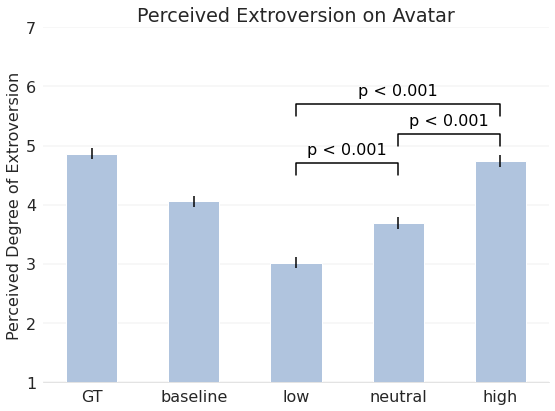

In [7]:
fig, ax = plt.subplots(figsize=(8, 6))

# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# set limit
ax.set_ylim(1, 7)

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.bar(
    labels, 
    height=[np.mean(x) for x in dataset], 
    yerr=[np.std(x)/np.sqrt(len(x)) for x in dataset],
    width=0.5,
    color="lightsteelblue",
)

annotate_between_bar(2, 3, bottom_height=4.5, text="p < 0.001")
annotate_between_bar(3, 4, bottom_height=5, text="p < 0.001")
annotate_between_bar(2, 4, bottom_height=5.5, text="p < 0.001")

ax.set_title("Perceived Extroversion on Avatar")
ax.set_ylabel("Perceived Degree of Extroversion")

plt.tight_layout()
plt.show()

In [8]:
print("Extroversion, with audio condition, commu")

dataset = [
    df["personality_gt_commu"],
    df["personality_icmi_commu"],
    df["personality_low_commu"],
    df["personality_mid_commu"],
    df["personality_high_commu"],
]

labels = [
    "GT",
    "baseline",
    "low",
    "neutral",
    "high"
]

print('--- ANOVA for 3 groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

Extroversion, with audio condition, commu
--- ANOVA for 3 groups ---
p-value = 2.3204916023964637e-28, f = 37.16506076026805
--- Pairwise Comparison ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
      GT baseline  -0.0533 0.9942 -0.4116  0.3049  False
      GT     high     0.28 0.2054 -0.0782  0.6382  False
      GT      low  -1.1333    0.0 -1.4916 -0.7751   True
      GT  neutral   0.1533 0.7683 -0.2049  0.5116  False
baseline     high   0.3333 0.0822 -0.0249  0.6916  False
baseline      low    -1.08    0.0 -1.4382 -0.7218   True
baseline  neutral   0.2067 0.5123 -0.1516  0.5649  False
    high      low  -1.4133    0.0 -1.7716 -1.0551   True
    high  neutral  -0.1267   0.87 -0.4849  0.2316  False
     low  neutral   1.2867    0.0  0.9284  1.6449   True
--------------------------------------------------------
GT: mean = 4.54, se = 0.09267865629870417
baselin

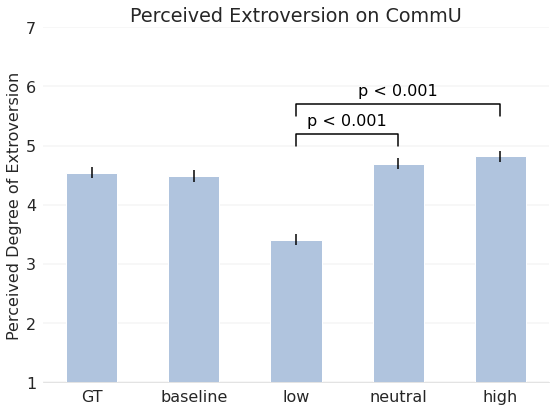

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# set limit
ax.set_ylim(1, 7)

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.bar(
    labels, 
    height=[np.mean(x) for x in dataset], 
    yerr=[np.std(x)/np.sqrt(len(x)) for x in dataset],
    width=0.5,
    color="lightsteelblue",
)

annotate_between_bar(2, 4, bottom_height=5.5, text="p < 0.001")
annotate_between_bar(2, 3, bottom_height=5, text="p < 0.001")

ax.set_title("Perceived Extroversion on CommU")
ax.set_ylabel("Perceived Degree of Extroversion")


plt.tight_layout()
plt.show()

In [10]:
print("Excitement, with audio condition, avatar")

dataset = [
    df["tension_gt"],
    df["tension_icmi"],
    df["tension_low"],
    df["tension_mid"],
    df["tension_high"],
]

labels = [
    "GT",
    "baseline",
    "low",
    "neutral",
    "high"
]

print('--- ANOVA for 3 groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

Excitement, with audio condition, avatar
--- ANOVA for 3 groups ---
p-value = 1.6075486954047583e-44, f = 60.89131401261497
--- Pairwise Comparison ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
      GT baseline    -0.74    0.0 -1.0984 -0.3816   True
      GT     high   0.0733 0.9807  -0.285  0.4317  False
      GT      low  -1.6067    0.0  -1.965 -1.2483   True
      GT  neutral  -1.1267    0.0  -1.485 -0.7683   True
baseline     high   0.8133    0.0   0.455  1.1717   True
baseline      low  -0.8667    0.0  -1.225 -0.5083   True
baseline  neutral  -0.3867  0.027  -0.745 -0.0283   True
    high      low    -1.68    0.0 -2.0384 -1.3216   True
    high  neutral     -1.2    0.0 -1.5584 -0.8416   True
     low  neutral     0.48 0.0025  0.1216  0.8384   True
--------------------------------------------------------
GT: mean = 4.453333333333333, se = 0.0936122815620

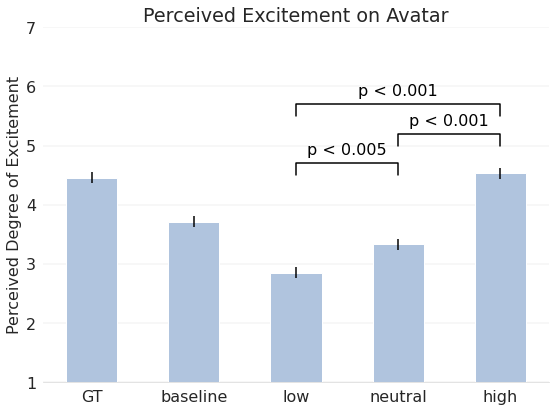

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# set limit
ax.set_ylim(1, 7)

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.bar(
    labels, 
    height=[np.mean(x) for x in dataset], 
    yerr=[np.std(x)/np.sqrt(len(x)) for x in dataset],
    width=0.5,
    color="lightsteelblue",
)

annotate_between_bar(2, 3, bottom_height=4.5, text="p < 0.005")
annotate_between_bar(3, 4, bottom_height=5, text="p < 0.001")
annotate_between_bar(2, 4, bottom_height=5.5, text="p < 0.001")

ax.set_title("Perceived Excitement on Avatar")
ax.set_ylabel("Perceived Degree of Excitement")

plt.tight_layout()
plt.show()

In [12]:
print("Excitement, with audio condition, commu")

dataset = [
    df["tension_gt_commu"],
    df["tension_icmi_commu"],
    df["tension_low_commu"],
    df["tension_mid_commu"],
    df["tension_high_commu"],
]

labels = [
    "GT",
    "baseline",
    "low",
    "neutral",
    "high"
]

print('--- ANOVA for 3 groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

Excitement, with audio condition, commu
--- ANOVA for 3 groups ---
p-value = 1.4515456617219211e-24, f = 31.909283229822307
--- Pairwise Comparison ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05   
 group1   group2  meandiff p-adj   lower   upper  reject
--------------------------------------------------------
      GT baseline  -0.0333 0.9991 -0.3911  0.3244  False
      GT     high   0.2667 0.2488 -0.0911  0.6244  False
      GT      low    -1.02    0.0 -1.3778 -0.6622   True
      GT  neutral   0.2133 0.4782 -0.1444  0.5711  False
baseline     high      0.3 0.1482 -0.0578  0.6578  False
baseline      low  -0.9867    0.0 -1.3444 -0.6289   True
baseline  neutral   0.2467 0.3261 -0.1111  0.6044  False
    high      low  -1.2867    0.0 -1.6444 -0.9289   True
    high  neutral  -0.0533 0.9942 -0.4111  0.3044  False
     low  neutral   1.2333    0.0  0.8756  1.5911   True
--------------------------------------------------------
GT: mean = 4.3533333333333335, se = 0.088008417105

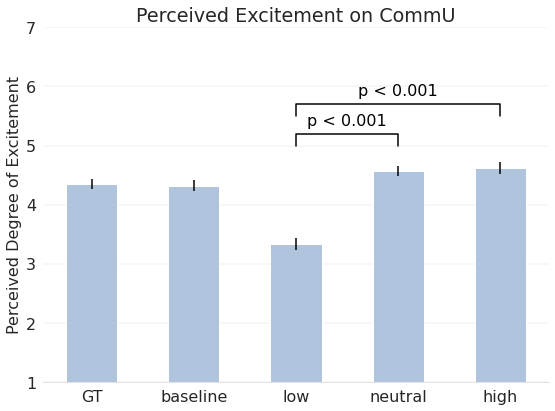

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))

# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# set limit
ax.set_ylim(1, 7)

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.bar(
    labels, 
    height=[np.mean(x) for x in dataset], 
    yerr=[np.std(x)/np.sqrt(len(x)) for x in dataset],
    width=0.5,
    color="lightsteelblue",
)

annotate_between_bar(2, 3, bottom_height=5, text="p < 0.001")
annotate_between_bar(2, 4, bottom_height=5.5, text="p < 0.001")

ax.set_title("Perceived Excitement on CommU")
ax.set_ylabel("Perceived Degree of Excitement")

plt.tight_layout()
plt.show()

In [14]:
print("extroversion, mismatch, with audio condition, avatar")

dataset = [
    df["personality_audio"],

    df["personality_low_mute"],
    df["personality_low"],

    df["personality_mid_mute"],
    df["personality_mid"],

    df["personality_high_mute"],
    df["personality_high"],
]

labels = [
    "audio only",
    "muted low",
    "low",
    "muted neutral",
    "neutral",
    "muted high",
    "high",
]

print('--- ANOVA for groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

extroversion, mismatch, with audio condition, avatar
--- ANOVA for groups ---
p-value = 2.1245250529224056e-107, f = 109.93044242018445
--- Pairwise Comparison ---
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
   audio only          high   0.6267 0.0001  0.2337  1.0196   True
   audio only           low     -1.1    0.0 -1.4929 -0.7071   True
   audio only    muted high   1.1333    0.0  0.7404  1.5263   True
   audio only     muted low  -1.7733    0.0 -2.1663 -1.3804   True
   audio only muted neutral  -0.3933 0.0496 -0.7863 -0.0004   True
   audio only       neutral  -0.4267 0.0233 -0.8196 -0.0337   True
         high           low  -1.7267    0.0 -2.1196 -1.3337   True
         high    muted high   0.5067 0.0028  0.1137  0.8996   True
         high     muted low     -2.4    0.0 -2.7929 -2.0071   True
         high muted neutral    -

/tmp/ipykernel_96781/3547261102.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


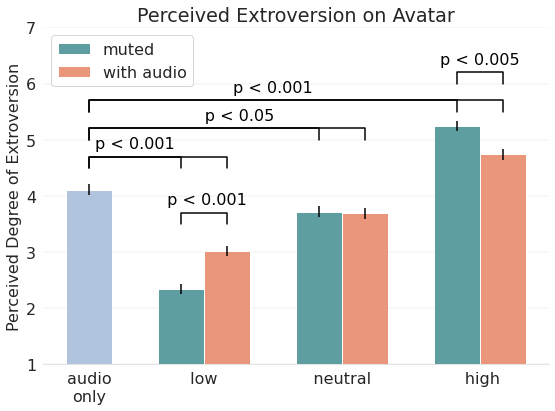

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))

# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# set limit
ax.set_ylim(1, 7)

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.bar(
    x=0, 
    height=np.mean(dataset[0]), 
    yerr=np.std(dataset[0])/np.sqrt(len(dataset[0])),
    width=0.25,
    color="lightsteelblue", 
)

# low
ax.bar(
    x=0.5, 
    height=np.mean(dataset[1]), 
    yerr=np.std(dataset[1])/np.sqrt(len(dataset[1])),
    width=0.25,
    color="cadetblue",
    label="muted"
)
ax.bar(
    x=0.75, 
    height=np.mean(dataset[2]), 
    yerr=np.std(dataset[2])/np.sqrt(len(dataset[2])),
    width=0.25,
    color="darksalmon",
    label="with audio"
)

# neutral
ax.bar(
    x=1.25, 
    height=np.mean(dataset[3]), 
    yerr=np.std(dataset[3])/np.sqrt(len(dataset[3])),
    width=0.25,
    color="cadetblue",
)
ax.bar(
    x=1.5, 
    height=np.mean(dataset[4]), 
    yerr=np.std(dataset[4])/np.sqrt(len(dataset[4])),
    width=0.25,
    color="darksalmon",
)

# high
ax.bar(
    x=2, 
    height=np.mean(dataset[5]), 
    yerr=np.std(dataset[5])/np.sqrt(len(dataset[5])),
    width=0.25,
    color="cadetblue",
)
ax.bar(
    x=2.25, 
    height=np.mean(dataset[6]), 
    yerr=np.std(dataset[6])/np.sqrt(len(dataset[6])),
    width=0.25,
    color="darksalmon",
)


ax.set_xticklabels([
    "placeholder", 
    "audio\nonly",
    "         low",
    "                           neutral",
    "                                              high"
])

ax.legend(loc="upper left")

annotate_between_bar(0, 0.5, bottom_height=4.5, text="p < 0.001")
annotate_between_bar(0, 0.75, bottom_height=4.5, text="")
annotate_between_bar(0.5, 0.75, bottom_height=3.5, text=" p < 0.001")

annotate_between_bar(0, 1.25, bottom_height=5, text="              p < 0.05")
annotate_between_bar(0, 1.5, bottom_height=5, text="")

annotate_between_bar(0, 2, bottom_height=5.5, text="p < 0.001")
annotate_between_bar(0, 2.25, bottom_height=5.5, text="")
annotate_between_bar(2, 2.25, bottom_height=6, text="p < 0.005")

ax.set_title("Perceived Extroversion on Avatar")
ax.set_ylabel("Perceived Degree of Extroversion")

plt.tight_layout()
plt.show()

In [16]:
print("excitement, mismatch, with audio condition, avatar")

dataset = [
    df["tension_audio"],

    df["tension_low_mute"],
    df["tension_low"],

    df["tension_mid_mute"],
    df["tension_mid"],

    df["tension_high_mute"],
    df["tension_high"],
]

labels = [
    "audio only",
    "muted low",
    "low",
    "muted neutral",
    "neutral",
    "muted high",
    "high",
]

print('--- ANOVA for groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

excitement, mismatch, with audio condition, avatar
--- ANOVA for groups ---
p-value = 3.9670744442088495e-95, f = 94.86970418613602
--- Pairwise Comparison ---
       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
    group1        group2    meandiff p-adj   lower   upper  reject
------------------------------------------------------------------
   audio only          high   0.5267 0.0026  0.1206  0.9327   True
   audio only           low  -1.1533    0.0 -1.5594 -0.7473   True
   audio only    muted high     0.84    0.0  0.4339  1.2461   True
   audio only     muted low  -1.8733    0.0 -2.2794 -1.4673   True
   audio only muted neutral  -0.4933 0.0064 -0.8994 -0.0873   True
   audio only       neutral  -0.6733    0.0 -1.0794 -0.2673   True
         high           low    -1.68    0.0 -2.0861 -1.2739   True
         high    muted high   0.3133 0.2549 -0.0927  0.7194  False
         high     muted low     -2.4    0.0 -2.8061 -1.9939   True
         high muted neutral    -1.02

/tmp/ipykernel_96781/4018230305.py:85: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([


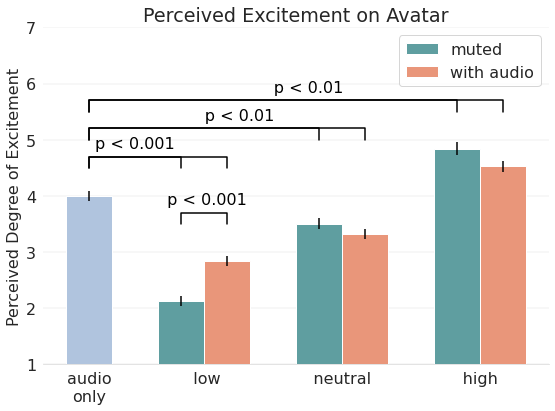

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))

# First, let's remove the top, right and left spines (figure borders)
# which really aren't necessary for a bar chart.
# Also, make the bottom spine gray instead of black.
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('#DDDDDD')

# Second, remove the ticks as well.
ax.tick_params(bottom=False, left=False)

# Third, add a horizontal grid (but keep the vertical grid hidden).
# Color the lines a light gray as well.
ax.set_axisbelow(True)
ax.yaxis.grid(True, color='#EEEEEE')
ax.xaxis.grid(False)

# set limit
ax.set_ylim(1, 7)

# Add major gridlines in the y-axis
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)

ax.bar(
    x=0, 
    height=np.mean(dataset[0]), 
    yerr=np.std(dataset[0])/np.sqrt(len(dataset[0])),
    width=0.25,
    color="lightsteelblue", 
)

# low
ax.bar(
    x=0.5, 
    height=np.mean(dataset[1]), 
    yerr=np.std(dataset[1])/np.sqrt(len(dataset[1])),
    width=0.25,
    color="cadetblue",
    label="muted"
)
ax.bar(
    x=0.75, 
    height=np.mean(dataset[2]), 
    yerr=np.std(dataset[2])/np.sqrt(len(dataset[2])),
    width=0.25,
    color="darksalmon",
    label="with audio"
)

# neutral
ax.bar(
    x=1.25, 
    height=np.mean(dataset[3]), 
    yerr=np.std(dataset[3])/np.sqrt(len(dataset[3])),
    width=0.25,
    color="cadetblue",
)
ax.bar(
    x=1.5, 
    height=np.mean(dataset[4]), 
    yerr=np.std(dataset[4])/np.sqrt(len(dataset[4])),
    width=0.25,
    color="darksalmon",
)

# high
ax.bar(
    x=2, 
    height=np.mean(dataset[5]), 
    yerr=np.std(dataset[5])/np.sqrt(len(dataset[5])),
    width=0.25,
    color="cadetblue",
)
ax.bar(
    x=2.25, 
    height=np.mean(dataset[6]), 
    yerr=np.std(dataset[6])/np.sqrt(len(dataset[6])),
    width=0.25,
    color="darksalmon",
)


ax.set_xticklabels([
    "placeholder", 
    "audio\nonly",
    "          low",
    "                           neutral",
    "                                             high"
])

ax.legend(loc="upper right")

annotate_between_bar(0, 0.5, bottom_height=4.5, text="p < 0.001")
annotate_between_bar(0, 0.75, bottom_height=4.5, text="")
annotate_between_bar(0.5, 0.75, bottom_height=3.5, text=" p < 0.001")

annotate_between_bar(0, 1.25, bottom_height=5, text="              p < 0.01")
annotate_between_bar(0, 1.5, bottom_height=5, text="")

annotate_between_bar(0, 2, bottom_height=5.5, text="              p < 0.01")
annotate_between_bar(0, 2.25, bottom_height=5.5, text="")

ax.set_title("Perceived Excitement on Avatar")
ax.set_ylabel("Perceived Degree of Excitement")

plt.tight_layout()
plt.show()

In [18]:
print("Extroversion, with audio condition, commu")

dataset = [
    df["personality_gt_commu"],
    df["personality_icmi_commu"],
    # df["personality_low_commu"],
    df["personality_mid_commu"],
    df["personality_high_commu"],
]

labels = [
    "GT",
    "baseline",
    # "low",
    "neutral",
    "high"
]

print('--- ANOVA for groups ---')
f, p = st.f_oneway(*dataset)
print(f"p-value = {p}, f = {f}")

print('--- Pairwise Comparison ---')
tukey_hsd(labels , *dataset)

for l, d in zip(labels, dataset):
    print("{}: mean = {}, se = {}".format(l, np.mean(d), np.std(d)/np.sqrt(len(d))))

Extroversion, with audio condition, commu
--- ANOVA for 3 groups ---
p-value = 0.04775550689176169, f = 2.654416237800747
--- Pairwise Comparison ---
  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
 group1   group2  meandiff p-adj   lower  upper  reject
-------------------------------------------------------
      GT baseline  -0.0533 0.9773 -0.3916  0.285  False
      GT     high     0.28 0.1441 -0.0583 0.6183  False
      GT  neutral   0.1533 0.6475  -0.185 0.4916  False
baseline     high   0.3333 0.0552  -0.005 0.6716  False
baseline  neutral   0.2067 0.3944 -0.1316  0.545  False
    high  neutral  -0.1267 0.7696  -0.465 0.2116  False
-------------------------------------------------------
GT: mean = 4.54, se = 0.09267865629870417
baseline: mean = 4.486666666666666, se = 0.09648795741400026
neutral: mean = 4.693333333333333, se = 0.08991189102753956
high: mean = 4.82, se = 0.09095542253702574
